In [1]:
#alll libraries i need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.metrics import accuracy_score ,classification_report ,roc_curve, auc ,precision_recall_curve


In [2]:
# Define paths
train_folder = "/kaggle/input/egyptian-hieroglyphs/train/"
valid_folder = "/kaggle/input/egyptian-hieroglyphs/valid/"
test_folder = "/kaggle/input/egyptian-hieroglyphs/test/"

# Load CSV files
train_data_df = pd.read_csv("/kaggle/input/egyptian-hieroglyphs/train/_annotations.csv")
valid_data_df = pd.read_csv("/kaggle/input/egyptian-hieroglyphs/valid/_annotations.csv")
test_data_df = pd.read_csv("/kaggle/input/egyptian-hieroglyphs/test/_annotations.csv")
train_data_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,nile-fish-7-_jpg.rf.31e4278980878c47a1e6a2f8dd...,640,640,Nile_Fish,375,319,512,454
1,Her-8-_jpg.rf.32bcf63f4ae4d6aea53cea5b9c0059b4...,640,640,Her,211,247,368,339
2,composite_bow-34-_jpg.rf.33153e63f7158777c50d4...,640,640,Composite_Bow,158,183,336,282
3,snake-6-_jpg.rf.32ac52ece4bcc06b1ead936693df17...,640,640,Snake,181,351,318,506
4,king-26-_jpg.rf.329a5a8e366f4fe2e3a3dca88524cc...,640,640,King,218,290,339,524
...,...,...,...,...,...,...,...,...
2718,limits-3-_jpg.rf.fe51052a18bcf65204ef3da4147d1...,640,640,Limit,356,339,471,498
2719,swallow-17-_jpg.rf.ff6d9c69bffa365d5dc7ff9dddb...,640,640,Swallow,350,339,524,445
2720,nursing-21-_jpg.rf.ff1a56a1ffcf9f41bf451e14c5c...,640,640,Nursing,320,217,416,367
2721,this-40-_jpg.rf.ffbb60d2c4951789b9e0b84b7ec2d0...,640,640,This,150,213,283,367


In [3]:
#check number of classes
no_class_tr = train_data_df['class'].nunique()
no_class_val = train_data_df['class'].nunique()
no_class_tes = train_data_df['class'].nunique()
print('train: ',no_class_tr,'valid: ',no_class_val,'test: ',no_class_tes)

train:  95 valid:  95 test:  95


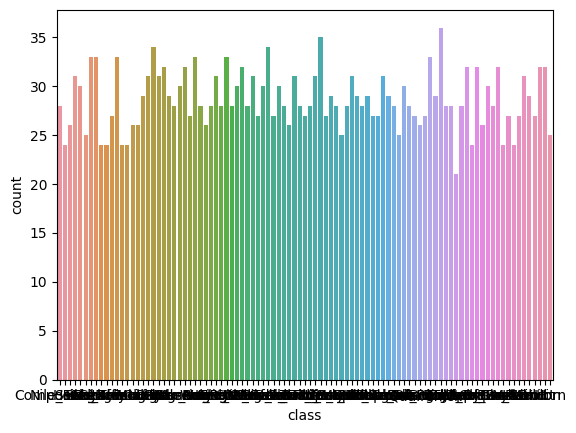

In [4]:
sns.countplot(data=train_data_df,x=train_data_df['class'])
plt.show()

In [5]:
# Get the value counts for the 'class' column
class_counts = train_data_df['class'].value_counts()


# Find the class with the minimum count
min_class = class_counts.idxmin()
min_count = class_counts.min()

# Find the class with the maximum count
max_class = class_counts.idxmax()
max_count = class_counts.max()

print(f"Class with minimum count: {min_class} (Count: {min_count})")
print(f"Class with maximum count: {max_class} (Count: {max_count})")


Class with minimum count: One (Count: 21)
Class with maximum count: Book (Count: 36)


In [6]:
def load_and_crop_images(data_df, folder_path):
    cropped_images = []
    labels = []
    
    for index, row in data_df.iterrows():
        # Construct the full image path
        img_path = os.path.join(folder_path, row['filename'])
        
        # Read the image
        img = cv2.imread(img_path)
        
        # Check if image is read correctly
        if img is not None:
            # Get bounding box coordinates
            xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
            
            # Crop the image using bounding box
            cropped_img = img[ymin:ymax, xmin:xmax]
            
            # Store the cropped image and label
            cropped_images.append(cropped_img)
            labels.append(row['class'])
        else:
            print(f"Image {img_path} not found.")
    
    return cropped_images, labels



In [7]:
train_images, train_labels = load_and_crop_images(train_data_df, train_folder)
valid_images, valid_labels = load_and_crop_images(valid_data_df, valid_folder)
test_images, test_labels = load_and_crop_images(test_data_df, test_folder)


In [8]:
def preprocess_images(images, target_size=(254, 254)):
    preprocessed_images = []
    
    for img in images:
        # Resize the image to target size
        resized_img = cv2.resize(img, target_size)
        
        # Convert BGR to RGB (OpenCV reads images in BGR format)
        rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
        
        # Rescale the image to range [0, 1] and convert to uint8
        scaled_img = (rgb_img / 255.0)  # Scale to [0, 1]
        scaled_img_uint8 = (scaled_img * 255).astype(np.uint8)  # Convert to [0, 255] and uint8
        
        # Store the preprocessed image
        preprocessed_images.append(scaled_img_uint8)
    
    return preprocessed_images


In [9]:
train_preprocessed_images = preprocess_images(train_images)
valid_preprocessed_images = preprocess_images(valid_images)
test_preprocessed_images = preprocess_images(test_images)


In [10]:
def display_images(images, labels, num_images=9):
    
    num_images = min(num_images, len(images), len(labels))
    random_indices = np.random.choice(len(images), num_images, replace=False)
    
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(random_indices):
        plt.subplot(3, 3, i + 1)  # Create a 3x3 grid
        plt.imshow(images[idx])  # Display the randomly selected image
        plt.title(labels[idx])  # Set the title to the corresponding label
        plt.axis('off')  # Hide axes
    plt.show()

In [11]:
print("Data type of first image:", train_preprocessed_images[0].dtype)
print("Shape of first image:", train_preprocessed_images[0].shape)


Data type of first image: uint8
Shape of first image: (254, 254, 3)


--------------------------------------Train Sample------------------------------


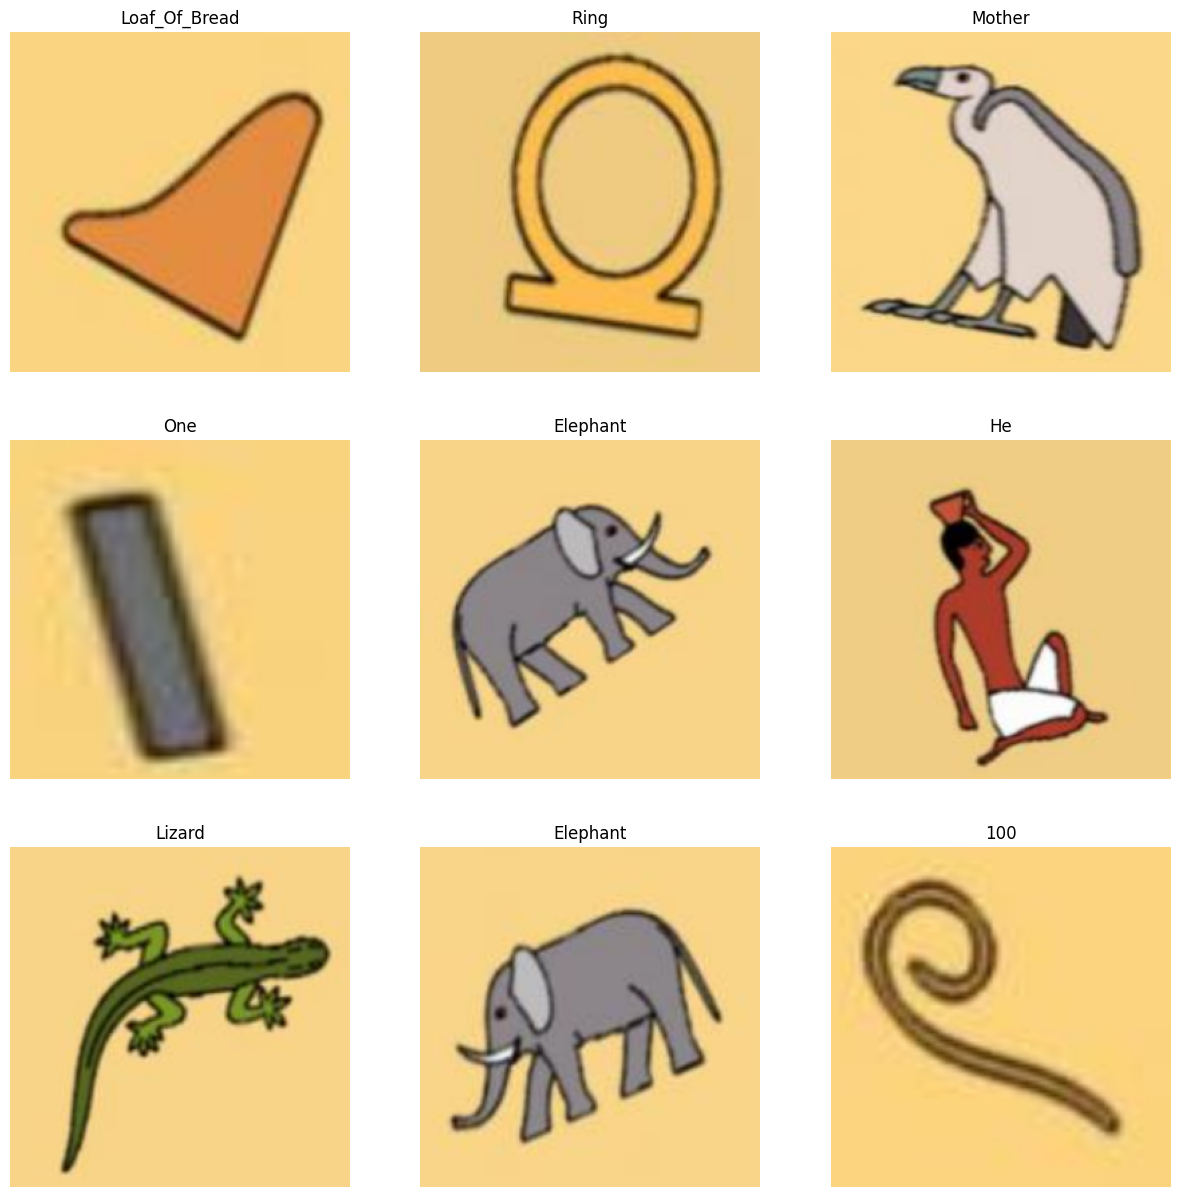

In [12]:
# Assuming you have corresponding labels for your training images
train_labels = train_data_df['class'].tolist()  # Adjust this based on your labels

print('--------------------------------------Train Sample------------------------------')
# Display the first 9 preprocessed images with labels
display_images(train_preprocessed_images, train_labels)


In [13]:
print(f'Number of validation images: {len(valid_preprocessed_images)}')
print(f'Number of validation labels: {len(valid_labels)}')

Number of validation images: 778
Number of validation labels: 778


--------------------------------------Valid Sample------------------------------


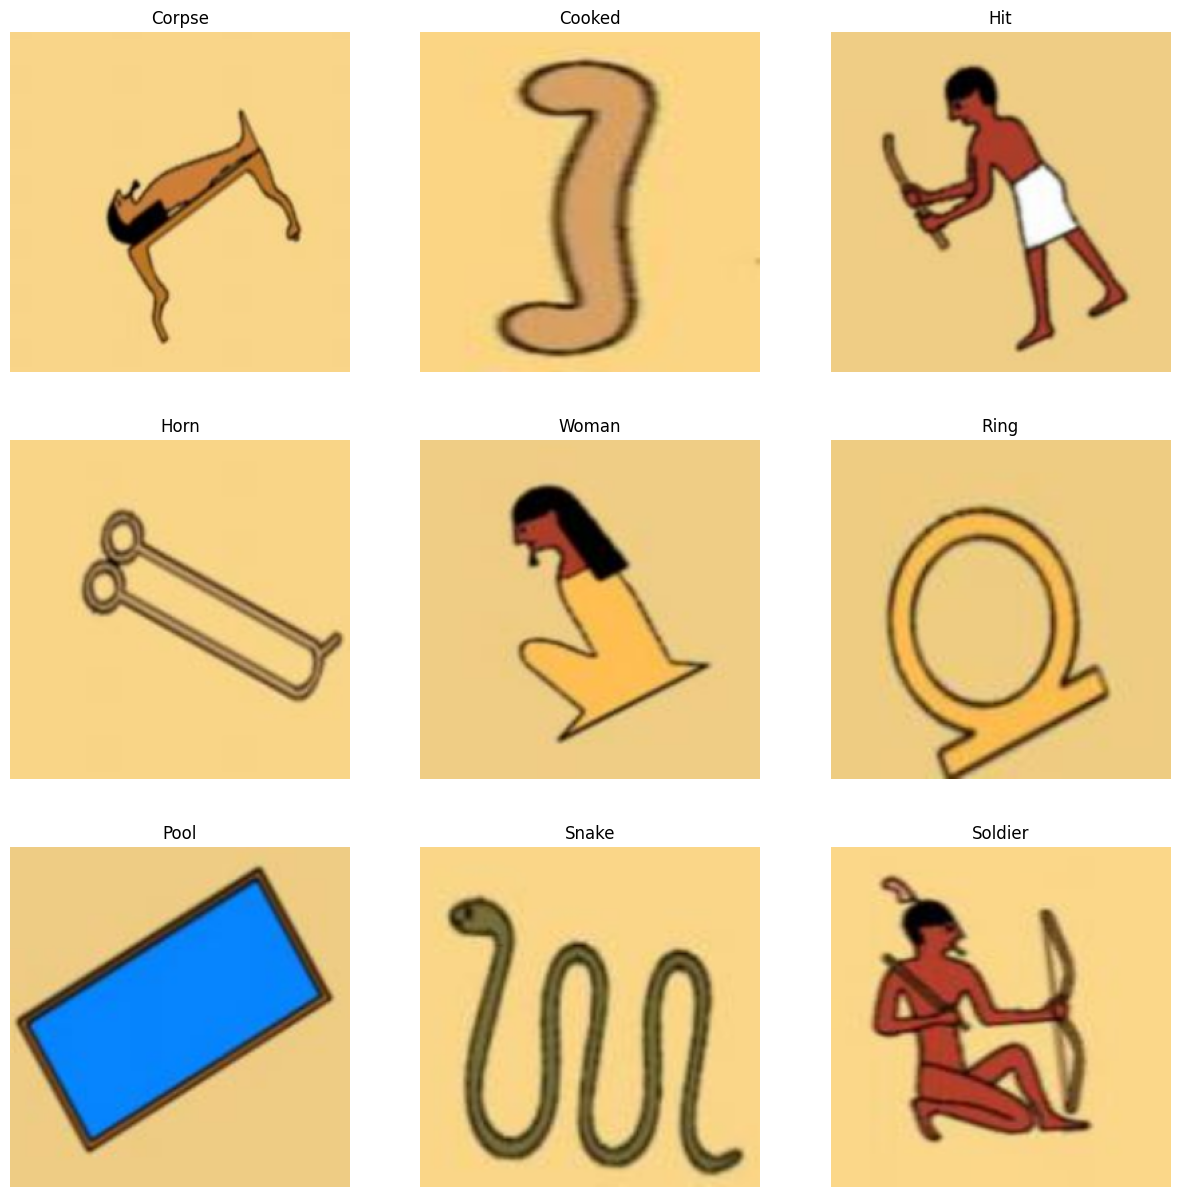

In [14]:
# Assuming you have corresponding labels for your training images
valid_labels = valid_data_df['class'].tolist()  # Adjust this based on your labels

print('--------------------------------------Valid Sample------------------------------')
# Display the first 9 preprocessed images with labels
display_images(valid_preprocessed_images, valid_labels)


--------------------------------------Test Sample------------------------------


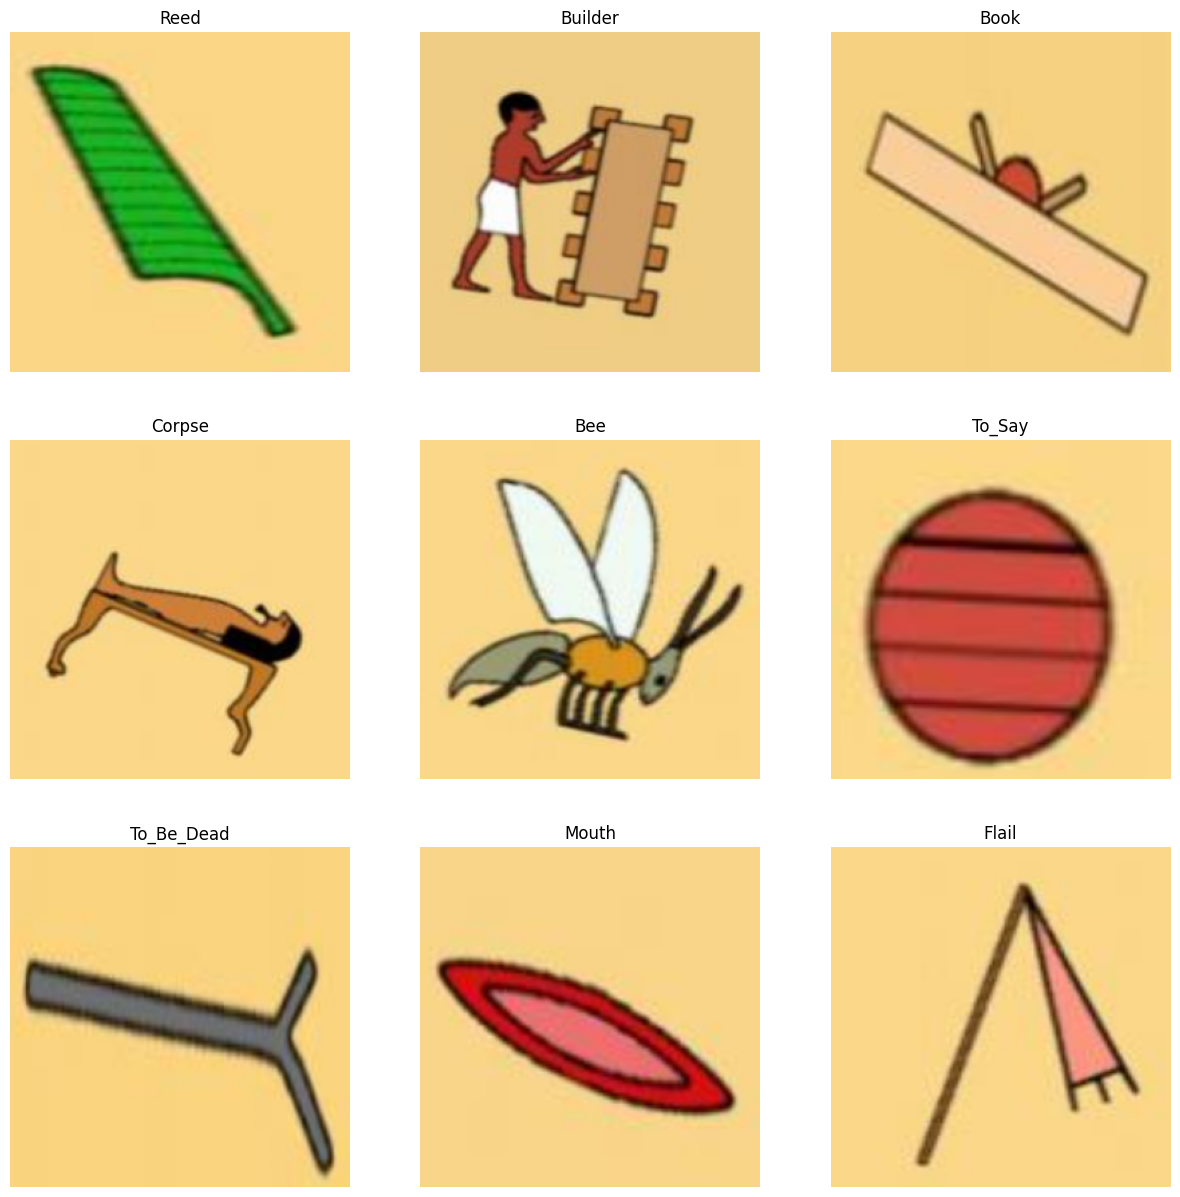

In [15]:
# Assuming you have corresponding labels for your training images
test_labels = test_data_df['class'].tolist()  # Adjust this based on your labels

print('--------------------------------------Test Sample------------------------------')
# Display the first 9 preprocessed images with labels
display_images(test_preprocessed_images, test_labels)


In [16]:
train_images = np.array(train_preprocessed_images)
valid_images = np.array(valid_preprocessed_images)
test_images = np.array(test_preprocessed_images)



# Convert to NumPy array
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)
train_images.shape
#train_images = train_preprocessed_images.reshape()

(2723, 254, 254, 3)

In [17]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator()  # Only rescale for validation

In [18]:
print(f'Number of validation images: {len(train_preprocessed_images)}')
print(f'Number of validation labels: {len(train_labels)}')

Number of validation images: 2723
Number of validation labels: 2723


In [19]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit the encoder to your labels and transform them
train_labels_encoded = label_encoder.fit_transform(train_labels)
valid_labels_encoded = label_encoder.transform(valid_labels)

# Now convert to categorical (one-hot encoding)
train_labels_categorical = to_categorical(train_labels_encoded)
valid_labels_categorical = to_categorical(valid_labels_encoded)

'''train_labels = train_labels_categorical.flatten()
valid_labels = valid_labels_categorical.flatten()
test_labels = test_labels_categorical.flatten()'''

'train_labels = train_labels_categorical.flatten()\nvalid_labels = valid_labels_categorical.flatten()\ntest_labels = test_labels_categorical.flatten()'

In [20]:
train_generator = train_datagen.flow(train_images,
                                      train_labels_categorical,
                                      batch_size=64,
                                      shuffle=True)

valid_generator = valid_datagen.flow(valid_images,
                                      valid_labels_categorical,
                                      batch_size=64,
                                      shuffle=False)

# CNN Model

In [21]:
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow import keras

# Image size and number of classes
img_size = (254, 254, 3)
no_class_tr = 95


# Creating the model using the Sequential API
def create_simple_cnn(input_shape):
    model = keras.models.Sequential()
    # First Conv Layer with regularization
    model.add(keras.layers.Conv2D(64, kernel_size=4, padding="same", activation="relu", 
                                  kernel_initializer="he_normal", 
                                  kernel_regularizer=regularizers.l2(0.001),
                                  input_shape=input_shape))
    # Second Conv Layer with Batch Normalization
    model.add(keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu", 
                                  kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=2))

    # Third Conv Layer
    model.add(keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu", 
                                  kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=2))

    # Dropout to prevent overfitting
    model.add(keras.layers.Dropout(0.3))

    # Fourth Conv Layer
    model.add(keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu", 
                                  kernel_initializer="he_normal", 
                                  kernel_regularizer=regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=2))

    # Increased Dropout
    model.add(keras.layers.Dropout(0.5))

    # Flattening the output for Dense layers
    model.add(keras.layers.Flatten())

    # Fully connected layers
    model.add(keras.layers.Dense(128, kernel_initializer='he_normal', activation='relu'))
    model.add(keras.layers.Dense(64, kernel_initializer='he_normal', activation='relu'))

    # Output layer
    model.add(keras.layers.Dense(no_class_tr, activation="softmax"))

    return model


In [22]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

callbacks = [early_stopping, model_checkpoint]

# Create the model
cnn_model = create_simple_cnn(img_size)

# Compile the model with a reduced learning rate
cnn_model.compile(optimizer='nadam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'recall'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 254, 254, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 127, 127, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 127, 127, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 63, 63, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,936,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 95)             │         6,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,009,887 (15.30 MB)

 Trainable params: 4,009,631 (15.30 MB)

 Non-trainable params: 256 (1.00 KB)

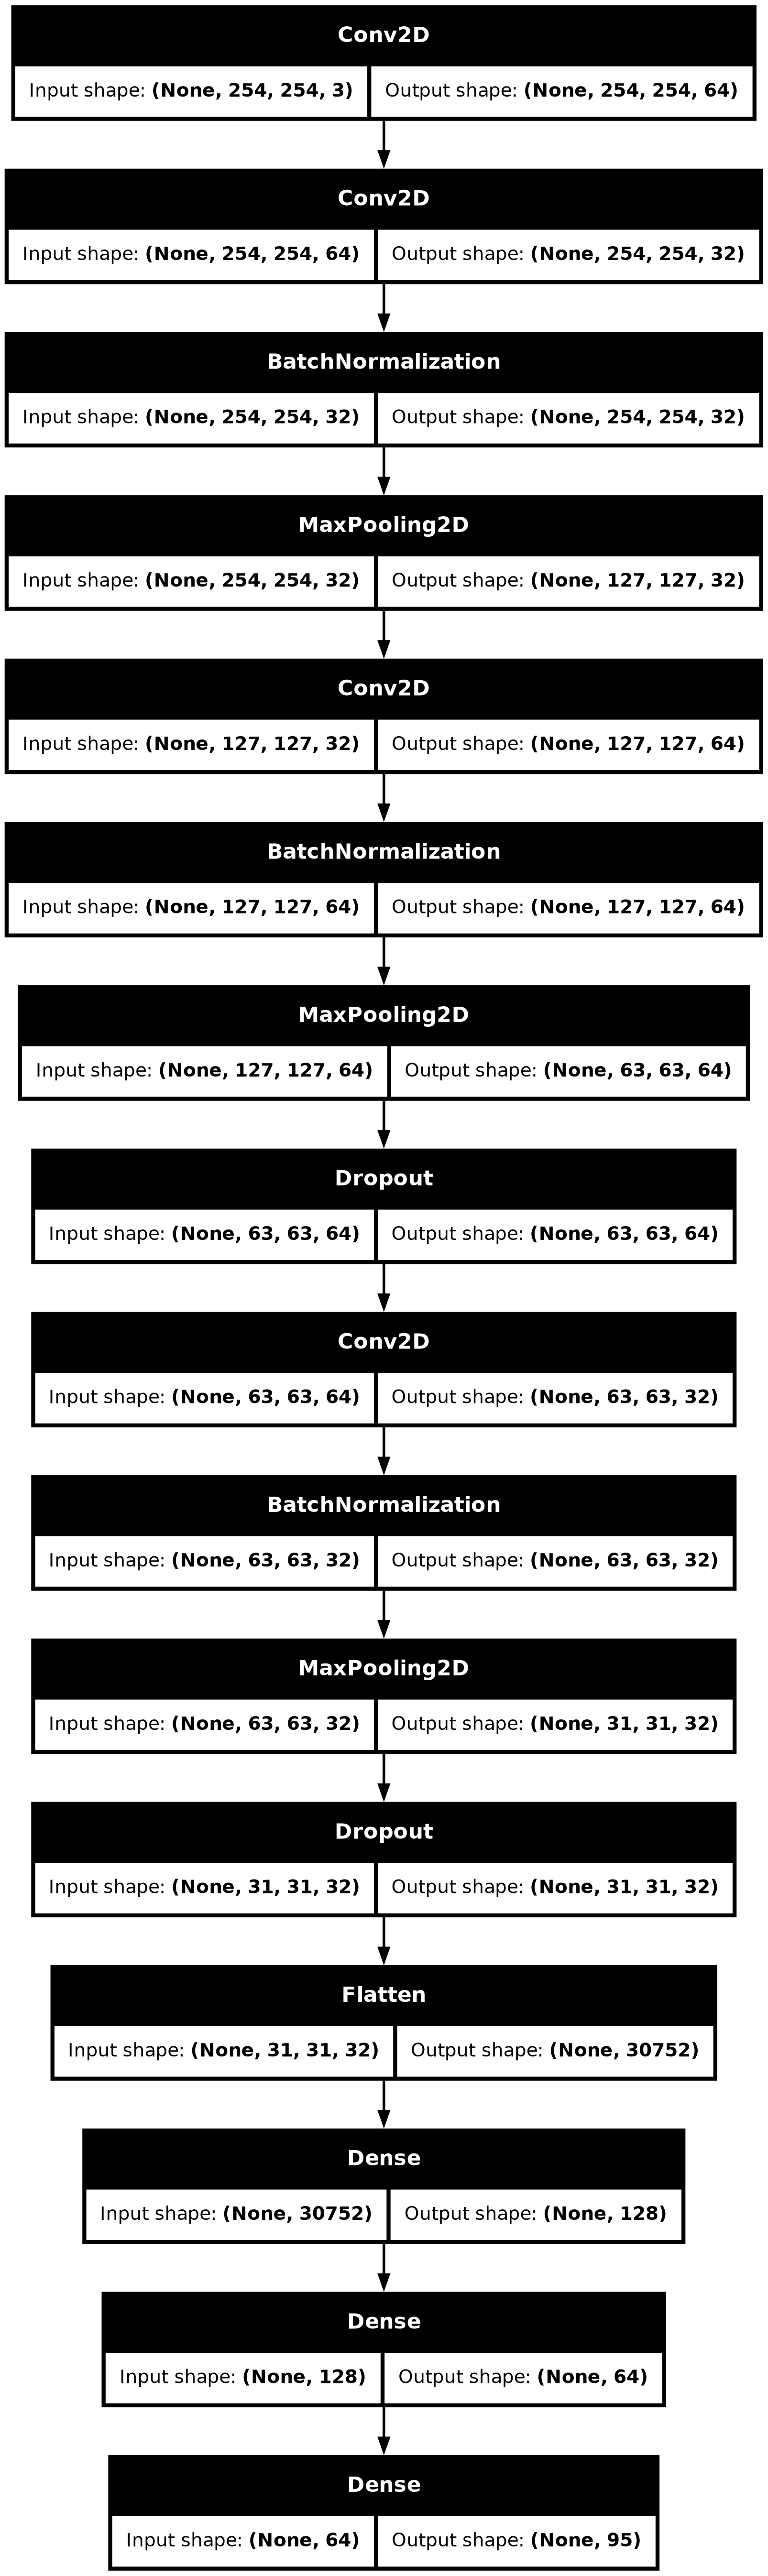

In [24]:
# Plot the model
from tensorflow.keras.utils import plot_model
plot_model(cnn_model, show_shapes=True)

In [25]:
history = cnn_model.fit(
    train_generator,
    epochs=100,
    validation_data=valid_generator,
    callbacks=callbacks
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729840897.936442     104 service.cc:145] XLA service 0x792648001740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729840897.936505     104 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729840897.936511     104 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-10-25 07:21:46.904171: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,254,254]{3,2,1,0}, f32[32,64,3,3]{3,2,1,0},

43/43 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.0357 - loss: 5.2965 - precision: 0.2709 - recall: 0.0079 - val_accuracy: 0.0141 - val_loss: 64.2633 - val_precision: 0.0141 - val_recall: 0.0141
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 37s 724ms/step - accuracy: 0.2273 - loss: 3.4638 - precision: 0.7249 - recall: 0.0954 - val_accuracy: 0.0129 - val_loss: 86.8660 - val_precision: 0.0129 - val_recall: 0.0129
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 37s 720ms/step - accuracy: 0.4821 - loss: 2.0664 - precision: 0.7941 - recall: 0.3329 - val_accuracy: 0.0244 - val_loss: 75.5625 - val_precision: 0.0249 - val_recall: 0.0244
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 37s 732ms/step - accuracy: 0.7202 - loss: 1.0752 - precision: 0.8241 - recall: 0.6109 - val_accuracy: 0.0334 - val_loss: 60.2712 - val_precision: 0.0353 - val_recall: 0.0334
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 37s 735ms/step - accuracy: 0.8191 - loss: 0.7217 - precision: 0.8715 - recall: 0.7642 - val_accuracy: 0.0180 - val_loss: 75.

In [26]:
#plotting training values
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall =history.history['recall']
val_recall =history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

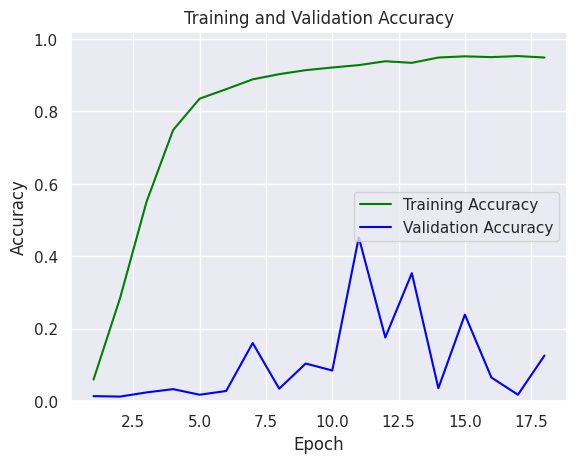

In [27]:
#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0,1.02)
plt.show()

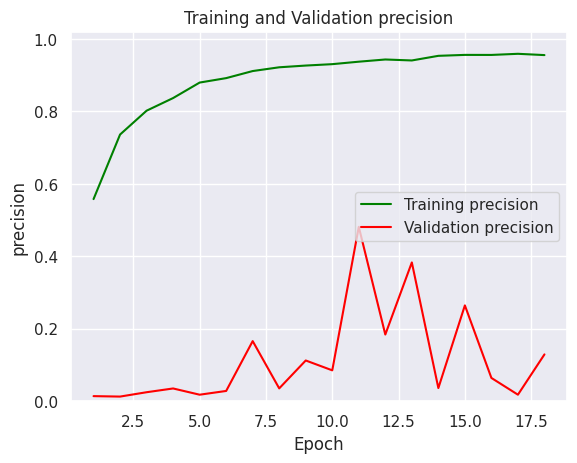

In [28]:
plt.figure()
#loss plot
plt.plot(epochs, precision, color='green', label='Training precision')
plt.plot(epochs, val_precision, color='red', label='Validation precision')
plt.title('Training and Validation precision')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend()
plt.ylim(0,1.02)
plt.show()

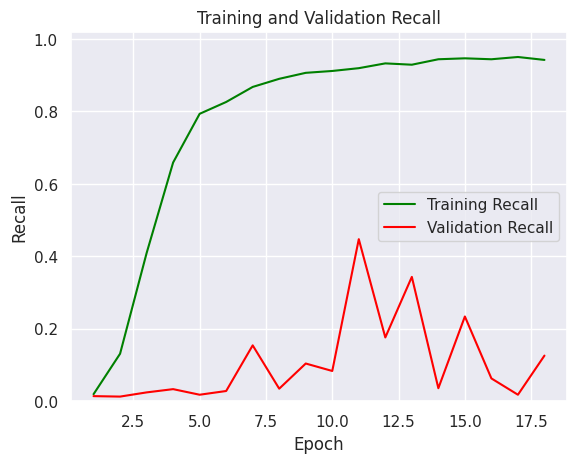

In [29]:
plt.figure()
#loss plot
plt.plot(epochs, recall, color='green', label='Training Recall')
plt.plot(epochs, val_recall, color='red', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.ylim(0,1.02)
plt.show()

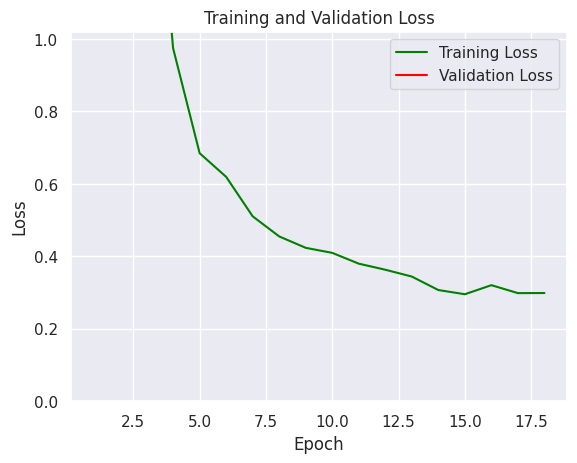

In [30]:
plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0,1.02)
plt.show()

In [ ]:
model.save('Resnet50_Cancer.h5')

In [ ]:
model = tf.keras.models.load_model("/kaggle/working/Resnet50_Cancer.h5")